## Trying to make a better jump function with smaller HVC size, a lot of improvements and retuning required.

In [12]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from numpy import core
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
from functions import *
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch

In [13]:
# running conditions
N_DAILY_MOTIFS = 1000 # trials per day per syllable  # old code N_DAILY_MOTIFS
N_DAYS_INTACT = 60 # days for learning
N_SYLL = 1
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 24 # SEED 3 both jump and without jump learn 
print(f'Random seed is {RANDOM_SEED}')
np.random.seed(RANDOM_SEED)

Random seed is 24


In [14]:
N_TRIAL_PER_SYLL = N_DAILY_MOTIFS * N_DAYS_INTACT
N_INTACT_TRIALS = N_TRIAL_PER_SYLL * N_SYLL
N_LESION_DAYS = 1
N_TOTAL_TRIALS = N_INTACT_TRIALS + N_LESION_DAYS * N_DAILY_MOTIFS * N_SYLL
DAYS = N_DAYS_INTACT + N_LESION_DAYS

In [15]:
# modes
JUMP = 1
HARD_BOUND = 0
ANNEALING = 1
# jump 0
if JUMP == 0:
    ANNEALING_SLOPE = 4
    ANNEALING_MID = 3
elif JUMP == 1:
    # jump 1 
    ANNEALING_MID = 0.4
    ANNEALING_SLOPE = 10

HEBBIAN_LEARNING = True
LOG_NORMAL = False
balance_factor = 3
BG_influence = True

# parameters
REWARD_WINDOW = 10
BG_NOISE = 0.1

# Landscape
LANDSCAPE = 0 # 0 for artificiall; 1 for syrinx

# Run paraneters
N_DISTRACTORS = 10
LEARING_RATE_RL = 0.07
LEARNING_RATE_HL = 2e-5 # small increase compared to CODE_8

# sigmoid layer parameters
BG_SIG_SLOPE = 2.5  # uniform output 
BG_sig_MID = 0
RA_SIG_SLOPE = 18 # most steep such that MC output is not skewed
RA_sig_MID = 0
# Sigmoid on MC is removed
# MC_SIG_SLOPE = 1 # 5 if lesser -> more difficult to climb the hill, assymptotes before 
# MC_sig_MID = 0

# layer sizes
HVC_SIZE = 100
BG_SIZE = 50
RA_SIZE = 100 
MC_SIZE = 2
N_RA_CLUSTERS = MC_SIZE
N_BG_CLUSTERS = 2
LIMIT = 1.5

In [16]:
# Model
class NN:
    def __init__(self, hvc_size, bg_size, ra_size, mc_size):
        if LOG_NORMAL:
            self.W_hvc_bg = sym_lognormal_samples(minimum = -1, maximum = 1, size = (hvc_size, bg_size)) # changing from -1 to 1 
            self.W_hvc_ra = np.zeros((hvc_size, ra_size)) # connections start from 0 and then increase
            self.W_bg_ra = lognormal_weight((bg_size, ra_size)) # const from 0 to 1
            self.W_ra_mc = lognormal_weight((ra_size, mc_size)) # const from 0 to 1
        else:
            self.W_hvc_bg = np.random.uniform(-1,1,(hvc_size, bg_size)) # changing from -1 to 1 
            self.W_hvc_ra = np.zeros((hvc_size, ra_size)) # connections start from 0 and then increase
            self.W_bg_ra = np.random.uniform(0, 1, (bg_size, ra_size)) # const from 0 to 1
            self.W_ra_mc = np.random.uniform(0, 1, (ra_size, mc_size)) # const from 0 to 1
        # Creating channels
        # channel from ra to mc
        for i in range(N_RA_CLUSTERS):
            segPath = np.diag(np.ones(N_RA_CLUSTERS, int))[i]
            self.W_ra_mc[i*ra_size//N_RA_CLUSTERS : (i+1)*ra_size//N_RA_CLUSTERS] *= segPath
        # channel from bg to ra such that motor cortex components are independent of each other
        for i in range(N_BG_CLUSTERS):
            segPath = np.diag(np.ones(N_BG_CLUSTERS, int))[i]
            self.W_bg_ra[i*bg_size//N_BG_CLUSTERS : (i+1)*bg_size//N_BG_CLUSTERS] *= [j for j in segPath for r in range(RA_SIZE//N_BG_CLUSTERS)]

        self.hvc_size = hvc_size
        self.bg_size = bg_size
        self.ra_size = ra_size
        self.mc_size = mc_size  
        self.ra_cluster_size = ra_size // N_RA_CLUSTERS
        self.bg_cluster_size = bg_size // N_BG_CLUSTERS
        self.bg_influence = BG_influence
            
    def forward(self, hvc_array):
        self.hvc = hvc_array
        if LANDSCAPE == 0: 
            span = 1.25
        else:
            span = 1
        # count number of 1 in hvc, divide bg by that number
        num_ones = np.count_nonzero(hvc_array == 1)
        self.bg = new_sigmoid(np.dot(hvc_array/num_ones, self.W_hvc_bg) + np.random.normal(0, BG_NOISE, self.bg_size), m = BG_SIG_SLOPE, a = BG_sig_MID)
        self.ra = new_sigmoid(np.dot(self.bg, self.W_bg_ra/np.sum(self.W_bg_ra, axis=0)) * balance_factor * self.bg_influence + np.dot(hvc_array/num_ones, self.W_hvc_ra)* HEBBIAN_LEARNING, m = RA_SIG_SLOPE, a = RA_sig_MID) 
        self.mc = span*np.dot(self.ra, self.W_ra_mc/np.sum(self.W_ra_mc, axis=0)) # outputs to +-0.50
        ''' even after BG cut off, output should remain still the same'''
        # below code is only for testing without sigmoidal functions
        # self.mc = new_sigmoid(np.dot(self.ra, self.W_ra_mc/np.sum(self.W_ra_mc, axis=0)), m = MC_SIG_SLOPE, a = MC_sig_MID)
        # self.bg = np.dot(hvc_array/num_ones, self.W_hvc_bg)  #outputs to +-0.98
        # self.ra = np.dot(self.bg, self.W_bg_ra/np.sum(self.W_bg_ra, axis=0)) * balance_factor  + np.dot(hvc_array/num_ones, self.W_hvc_ra)* HEBBIAN_LEARNING #outputs to +-0.40
        return self.mc, self.ra, self.bg

In [17]:
# helper function 
def find_sigma_with_height(height):
    sigma = 1/np.sqrt(2*np.pi*height)
    return sigma

print(find_sigma_with_height(0.8))

0.44603102903819275


In [18]:
class Environment:
    def __init__(self, hvc_size, bg_size, ra_size, mc_size, seed):
        self.hvc_size = hvc_size
        self.bg_size = bg_size
        self.ra_size = ra_size
        self.mc_size = mc_size
        self.seed = seed
        self.model = NN(hvc_size, bg_size, ra_size, mc_size)
        # landscape parameters
        if LANDSCAPE == 0: # artificial landscape
            self.centers = np.random.uniform(-0.9, 0.9, (N_SYLL, 2))
            self.heights = np.random.uniform(0.2, 0.7, (N_SYLL, N_DISTRACTORS))
            self.means = np.random.uniform(-1, 1, (N_SYLL,N_DISTRACTORS, 2))
            self.spreads = np.random.uniform(0.1, 0.6, (N_SYLL, N_DISTRACTORS))
        else: # Syrinx landscape
            if N_SYLL > 4:
                raise ValueError('Only 4 syllables are available in the syrinx landscape')
            self.syrinx_contours = []
            self.syrinx_targets = []
            for syll in range(N_SYLL):
                base = np.load(f"contours/Syll{syll+1}.npy")
                Z, target = make_contour(base)
                self.syrinx_contours.append(Z)
                self.syrinx_targets.append(target)
                self.centers = np.array(self.syrinx_targets)
            
        # data storage
        self.rewards = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))
        self.actions = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL, self.mc_size))
        self.hvc_bg_array = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))
        self.hvc_bg_array_all = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL, self.hvc_size, self.bg_size))   
        self.bg_out = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))
        self.hvc_ra_array = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))
        self.hvc_ra_array_all = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL, self.hvc_size, self.ra_size))   
        self.ra_out = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))
        self.RPE = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL)) 
        self.JUMP_RPE = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))
        self.ra_all = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL, self.ra_size))
        self.bg_all = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL, self.bg_size))
        self.dw_day_array = np.zeros((DAYS, N_SYLL))
        self.pot_array = np.zeros((DAYS, N_SYLL))

    def artificial_landscape(self, coordinates, syll):
        center = self.centers[syll, :]
        reward_scape = gaussian(coordinates, 1, center, 0.3)
        if N_DISTRACTORS == 0:
            return reward_scape
        hills = []
        hills.append(reward_scape)
        for i in range(N_DISTRACTORS):
            height = self.heights[syll, i]
            mean = self.means[syll, i,:]
            spread = self.spreads[syll, i]
            hills.append(gaussian(coordinates, height, mean, spread))
        return np.maximum.reduce(hills)
    
    def artificial_landscape_alt(self, coordinates, syll):
        center = self.centers[syll, :]
        reward_scape = gaussian(coordinates, 1, center, 0.3)
        if N_DISTRACTORS == 0:
            return reward_scape
        hills = []
        hills.append(reward_scape)
        for i in range(N_DISTRACTORS):
            height = self.heights[syll, i]
            mean = self.means[syll, i,:]
            spread = find_sigma_with_height(height)
            hills.append(gaussian(coordinates, height, mean, spread))
        return np.maximum.reduce(hills)
    
    def syrinx_landscape(self, coordinates, syll, n = 256):  
        contour = self.syrinx_contours[syll]
        target_pos = self.syrinx_targets[syll]
        x, y = coordinates[0], coordinates[1]
        x = max(min(x, 0.999), -1)
        y = max(min(y, 0.999), -1)
        x = int((x + 1) / 2 * n)
        y = int((y + 1) / 2 * n)
        return contour[x, y]

        
    def get_reward(self, coordinates, syll):
        # landscape creation and reward calculation
        if LANDSCAPE == False:
            return self.artificial_landscape(coordinates, syll)
        else:
            return self.syrinx_landscape(coordinates, syll)
     
    def run(self, learning_rate, learning_rate_hl, annealing = False):
        # modes 
        self.annealing = annealing
        self.model.bg_influence = True
        # each day, 1000 trial, n_syll syllables
        for day in tqdm(range(DAYS)):
            dw_day = np.zeros(N_SYLL)
            self.model.bg_influence = True
            if day >= DAYS: 
                self.model.bg_influence = False # BG lesion on the last day
            sum_RPE_1 = 0
            sum_RPE_2 = 0
            for iter in range(N_DAILY_MOTIFS):
                for syll in range(N_SYLL):
                    # input from HVC is determined by the syllable
                    input_hvc = np.zeros(HVC_SIZE)
                    input_hvc[syll] = 1
                    # reward, action and baseline
                    action, ra, bg = self.model.forward(input_hvc)
                    reward = self.get_reward(action, syll)
                    self.rewards[day, iter, syll] = reward
                    self.actions[day, iter, syll,:] = action
                    reward_baseline = 0
                    if iter < REWARD_WINDOW and iter > 0:
                        reward_baseline = np.mean(self.rewards[day, :iter, syll])
                    elif iter >= REWARD_WINDOW:
                        reward_baseline = np.mean(self.rewards[day, iter-REWARD_WINDOW:iter, syll])
                    # futute reward
                    if day < DAYS - 1:
                        if iter < N_DAILY_MOTIFS-1:
                            fut_RPE = self.rewards[day, iter+1, syll] - reward_baseline 
                        elif iter == N_DAILY_MOTIFS - 1:
                            fut_RPE = self.rewards[day+1, 0, syll] - reward_baseline
                    elif day == DAYS - 1:
                        fut_RPE = - reward_baseline # null trial

                
                    # Updating weights
                    # RL update
                    dw_hvc_bg = learning_rate*(reward - reward_baseline)*input_hvc.reshape(self.hvc_size,1)*self.model.bg * self.model.bg_influence # RL update
                    # self.model.W_hvc_bg += dw_hvc_bg
                    # HL update
                    dw_hvc_ra = learning_rate_hl*input_hvc.reshape(self.hvc_size,1)*self.model.ra*HEBBIAN_LEARNING # lr is supposed to be much smaller here
                    # self.model.W_hvc_ra += dw_hvc_ra
                    # bound weights between +-1
                    if HARD_BOUND == 1:
                        self.model.W_hvc_ra += dw_hvc_ra
                        self.model.W_hvc_bg += dw_hvc_bg
                        np.core.umath.maximum(np.core.umath.minimum(self.model.W_hvc_bg, 1, out = self.model.W_hvc_bg), -1, out = self.model.W_hvc_bg) # type: ignore
                        np.core.umath.maximum(np.core.umath.minimum(self.model.W_hvc_ra, 1, out = self.model.W_hvc_ra), -1, out = self.model.W_hvc_ra) # type: ignore
                    else:
                        self.model.W_hvc_bg += dw_hvc_bg*(1 - self.model.W_hvc_bg)*(self.model.W_hvc_bg + 1)
                        self.model.W_hvc_ra += dw_hvc_ra*(1 - self.model.W_hvc_ra)*(self.model.W_hvc_ra + 1)
                    # storing values for plotting
                    self.RPE[day, iter, syll] = reward - reward_baseline        
                    sum_RPE_1 += self.RPE[day, iter, syll] - self.RPE[day, iter - 1, syll]
                    sum_RPE_2 = sum_RPE_1
                    # self.JUMP_RPE[day, iter, syll] = sum_RPE_2 + reward_baseline
                    self.JUMP_RPE[day, iter, syll] = sum_RPE_2 - fut_RPE
                    dw_day[syll] += np.mean(np.abs(dw_hvc_bg))
                    self.hvc_bg_array[day, iter, syll] = self.model.W_hvc_bg[syll,1]
                    self.bg_out[day, iter, syll] = bg[1]
                    self.hvc_ra_array[day, iter, syll] = self.model.W_hvc_ra[syll,1]
                    self.hvc_ra_array_all[day, iter, syll, :] = self.model.W_hvc_ra[syll,:]
                    self.hvc_bg_array_all[day, iter, syll, :] = self.model.W_hvc_bg[syll,:]
                    self.ra_out[day, iter, syll] = ra[0]
                    self.ra_all[day, iter, syll, :] = ra
                    self.bg_all[day, iter, syll, :] = bg

            # if day % 1 == 0:   
            #     tqdm.write(f'Day: {day}, Action: {action}, Reward: {reward}, Reward Baseline: {reward_baseline}')  
            # Annealing
            if self.annealing:
                for syll in range(N_SYLL):
                    if JUMP == 0:
                        ''' input daily sum, output scaling factor for potentiation'''
                        # calculating potentiation 
                        d = dw_day[syll]*100 # scaling up to be comparable
                        p = 1 * sigmoid(1*d, m = ANNEALING_SLOPE, a = ANNEALING_MID)
                        potentiation_factor = np.zeros((self.hvc_size))
                        potentiation_factor[syll] = 1-p 
                        # implementing night weight changes
                        night_noise = np.random.uniform(-1, 1, self.bg_size) # make it lognormal
                        dw_night = LEARING_RATE_RL*potentiation_factor.reshape(self.hvc_size,1)*night_noise*10*self.model.bg_influence
                        self.model.W_hvc_bg += dw_night
                        self.model.W_hvc_bg = (self.model.W_hvc_bg + 1) % 2 -1 # bound between -1 and 1 in cyclical manner
                        # storing values
                        self.pot_array[day, syll] = 1-p
                        self.dw_day_array[day, syll] = d
                    elif JUMP == 1:
                        d = self.JUMP_RPE[day, iter, syll]
                        p = 1 * sigmoid(1*d, m = ANNEALING_SLOPE, a = ANNEALING_MID)
                        potentiation_factor = np.zeros((self.hvc_size))
                        potentiation_factor[syll] = 1-p 
                        # implementing night weight changes
                        night_noise = np.random.uniform(-1, 1, self.bg_size) # make it lognormal
                        dw_night = LEARING_RATE_RL*potentiation_factor.reshape(self.hvc_size,1)*night_noise*10*self.model.bg_influence
                        self.model.W_hvc_bg += dw_night
                        self.model.W_hvc_bg = (self.model.W_hvc_bg + 1) % 2 -1 # bound between -1 and 1 in cyclical manner
                        # storing values
                        self.pot_array[day, syll] = 1-p
                        self.dw_day_array[day, syll] = d
                    


    def generate_results(self, syll):   
        return self.ra_all[:,:,syll,:].reshape(DAYS*N_DAILY_MOTIFS, self.ra_size)
        
    def plot_results(self, syll):
        fig, axs = plt.subplots(6, 1, figsize=(10, 15))
        axs[0].plot(self.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, linestyle='None')
        axs[0].hlines(0.7, 0, DAYS*N_DAILY_MOTIFS, colors='r', linestyles='dashed')
        axs[0].set_ylim(0, 1)
        axs[0].set_ylabel('Reward')
        axs[1].plot(self.hvc_bg_array[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
        axs[1].set_ylim(-1, 1)
        axs[1].set_ylabel('HVC BG weights')
        axs[2].plot(self.bg_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS),'.', markersize=0.5, linestyle='None')
        axs[2].set_ylim(-1, 1)
        axs[2].set_ylabel('BG output')
        axs[3].plot(self.hvc_ra_array[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
        axs[3].set_ylim(-1, 1)
        axs[3].set_ylabel('HVC RA weights')
        axs[4].plot(self.actions[:,:,syll,0].reshape(DAYS*N_DAILY_MOTIFS))
        axs[4].plot(self.actions[:,:,syll,1].reshape(DAYS*N_DAILY_MOTIFS))
        axs[4].plot(self.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS))
        axs[4].plot(self.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS))
        axs[4].legend(['x target', 'y target'])
        axs[4].set_ylabel('Motor Output')
        axs[4].set_ylim(-1, 1)
        axs[5].plot(self.ra_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
        axs[5].set_ylim(-1, 1)
        axs[5].set_ylabel('RA activity')
        fig.suptitle('Results', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # type:ignore
        plt.show()
    
    def plot_dw_day(self, syll):
        if ANNEALING:
            fig, axs = plt.subplots(4,1,figsize=(10, 15))
            expanded_dw_day_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))
            expanded_pot_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))
            # Expand dw_day_array and pot_array to match the size of rewards
            expanded_dw_day_array = np.repeat(self.dw_day_array[:, syll], DAYS*N_DAILY_MOTIFS// len(self.dw_day_array[:, syll]))
            expanded_pot_array = np.repeat(self.pot_array[:, syll], DAYS*N_DAILY_MOTIFS// len(self.pot_array[:, syll]))
            fig.suptitle(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
            axs[0].set_title(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')  
            axs[0].plot(expanded_dw_day_array, markersize=1, label='dW_day')
            axs[0].set_ylim(0,10)
            axs[0].set_ylabel('dW_day')        
            axs[1].plot(expanded_pot_array, markersize=1, label='Potentiation factor')
            axs[1].set_ylabel('Potentiation factor')
            axs[2].plot(self.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='Reward', alpha = 0.1)
            axs[2].set_ylabel('Rewards')
            axs[2].set_ylim(0, 1)
            axs[3].plot(self.RPE[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='RPE', alpha = 0.1)               
            axs[3].set_ylabel('RPE')
            axs[3].set_ylim(-1, 1)
            for i in range(4):
                axs[i].vlines(range(0, DAYS*N_DAILY_MOTIFS, N_DAILY_MOTIFS), -3, 10, colors='b', linestyles='dashed')           
            plt.tight_layout()
            plt.show()

            
            # plt.plot(expanded_dw_day_array, markersize=1, label='dW_day')
            # plt.plot(expanded_pot_array, markersize=1, label='Potentiation factor')
            # plt.plot(self.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='Reward', alpha = 0.1)
            # plt.xlabel('Days')
            # plt.ylabel('dW_day')
            # plt.legend()
            # plt.show()  
        
    def save_trajectory(self, syll):
        fig, axs = plt.subplots(figsize=(10, 9))
        # generate grid 
        x, y = np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)
        X, Y = np.meshgrid(x, y)
        Z = self.get_reward([X, Y], syll)
        # Plot contour
        cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
        contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        
        # plot trajectory
        x_traj, y_traj = zip(*self.actions[:,:, syll,:].reshape(-1, 2))
        axs.plot(x_traj[::10], y_traj[::10], 'r', label='Agent Trajectory', alpha = 0.5, linewidth = 0.5) # Plot every 20th point for efficiency
        axs.scatter(x_traj[0], y_traj[0], s=20, c='b', label='Starting Point')  # Plot first point as red circle
        axs.scatter(x_traj[-5:], y_traj[-5:], s=20, c='r', marker='x', label='Ending Point') # type: ignore
        axs.scatter(self.centers[syll, 0], self.centers[syll, 1], s=20, c='y', marker='x', label='target')  # type: ignore
        # labels
        axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}')
        axs.set_xlabel('x')
        axs.set_ylabel('y')
        axs.legend()
        plt.tight_layout()
        # Create the "plots" directory if it doesn't exist
        os.makedirs(save_dir, exist_ok = True)
        # Clear previous plots (optional):
        # for filename in os.listdir(save_dir):
        #     if filename.startswith("trajectory") and filename.endswith(".png") or filename.endswith(".jpg"):
        #         os.remove(os.path.join(save_dir, filename))
        # Save the plot
        plt.savefig(os.path.join(save_dir, f"trajectory_{RANDOM_SEED}_{syll}.png"))
        plt.close()  # Close the plot to avoid memory leaks
        
    def save_results(self, syll):
        fig, axs = plt.subplots(6, 1, figsize=(10, 15))
        axs[0].plot(self.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, linestyle='None')
        axs[0].hlines(0.7, 0, DAYS*N_DAILY_MOTIFS, colors='r', linestyles='dashed')
        axs[0].set_ylim(0, 1)
        axs[0].set_ylabel('Reward')
        axs[1].plot(self.hvc_bg_array[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
        axs[1].set_ylim(-1, 1)
        axs[1].set_ylabel('HVC BG weights')
        axs[2].plot(self.bg_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS),'.', markersize=0.5, linestyle='None')
        axs[2].set_ylim(-1, 1)
        axs[2].set_ylabel('BG output')
        axs[3].plot(self.hvc_ra_array[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
        axs[3].set_ylim(-1, 1)
        axs[3].set_ylabel('HVC RA weights')
        axs[4].plot(self.actions[:,:,syll,0].reshape(DAYS*N_DAILY_MOTIFS))
        axs[4].plot(self.actions[:,:,syll,1].reshape(DAYS*N_DAILY_MOTIFS))
        axs[4].plot(self.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS))
        axs[4].plot(self.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS))
        axs[4].legend(['x target', 'y target'])
        axs[4].set_ylabel('Motor Output')
        axs[4].set_ylim(-1, 1)
        axs[5].plot(self.ra_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
        axs[5].set_ylim(-1, 1)
        axs[5].set_ylabel('RA activity')
        fig.suptitle(f'Results SEED:{RANDOM_SEED} syllable: {syll}', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # type: ignore 
        # Create the "plots" directory if it doesn't exist
        os.makedirs(save_dir, exist_ok = True)
        # Clear previous plots (optional):
        # for filename in os.listdir(save_dir):
        #     if filename.startswith("results") and filename.endswith(".png") or filename.endswith(".jpg"):
        #         os.remove(os.path.join(save_dir, filename))
        # Save the plot
        plt.savefig(os.path.join(save_dir, f"results_{RANDOM_SEED}_{syll}.png"))
        plt.close()  # Close the plot to avoid memory leaks
        
    def save_dw_day(self, syll):
        if ANNEALING:
            expanded_dw_day_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))
            expanded_pot_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))
            # Expand dw_day_array and pot_array to match the size of rewards
            expanded_dw_day_array = np.repeat(self.dw_day_array[:, syll], DAYS*N_DAILY_MOTIFS// len(self.dw_day_array[:, syll]))
            expanded_pot_array = np.repeat(self.pot_array[:, syll], DAYS*N_DAILY_MOTIFS// len(self.pot_array[:, syll]))
            plt.title(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
            plt.plot(expanded_dw_day_array, markersize=1, label='dW_day')
            plt.plot(expanded_pot_array, markersize=1, label='Potentiation factor')
            plt.plot(self.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='Reward', alpha = 0.1)
            plt.xlabel('Days')
            plt.ylabel('dW_day')
            plt.legend()
            # Create the "plots" directory if it doesn't exist
            os.makedirs(save_dir, exist_ok = True)
            # # Clear previous plots (optional):
            # for filename in os.listdir(save_dir):
            #     if filename.startswith("dw") and filename.endswith(".png") or filename.endswith(".jpg"):
            #         os.remove(os.path.join(save_dir, filename))
            # Save the plot
            plt.savefig(os.path.join(save_dir, f"dw_{RANDOM_SEED}_{syll}.png"))
            plt.close()  # Close the plot to avoid memory leaks         
    

In [19]:
obj = Environment(HVC_SIZE, BG_SIZE, RA_SIZE, MC_SIZE, RANDOM_SEED)
obj.run(LEARING_RATE_RL, LEARNING_RATE_HL, ANNEALING) # type: ignore 
# remove_prev_files()



  5%|▍         | 3/61 [00:00<00:06,  8.30it/s]

100%|██████████| 61/61 [00:07<00:00,  8.44it/s]


In [20]:
# correlation between RPE and JUMP_RPE
print(np.corrcoef(obj.JUMP_RPE.reshape(DAYS*N_DAILY_MOTIFS), obj.RPE.reshape(DAYS*N_DAILY_MOTIFS))[0,1])

print(np.corrcoef(obj.JUMP_RPE.reshape(DAYS*N_DAILY_MOTIFS), obj.rewards.reshape(DAYS*N_DAILY_MOTIFS))[0,1])


0.18903115772251683
1.0


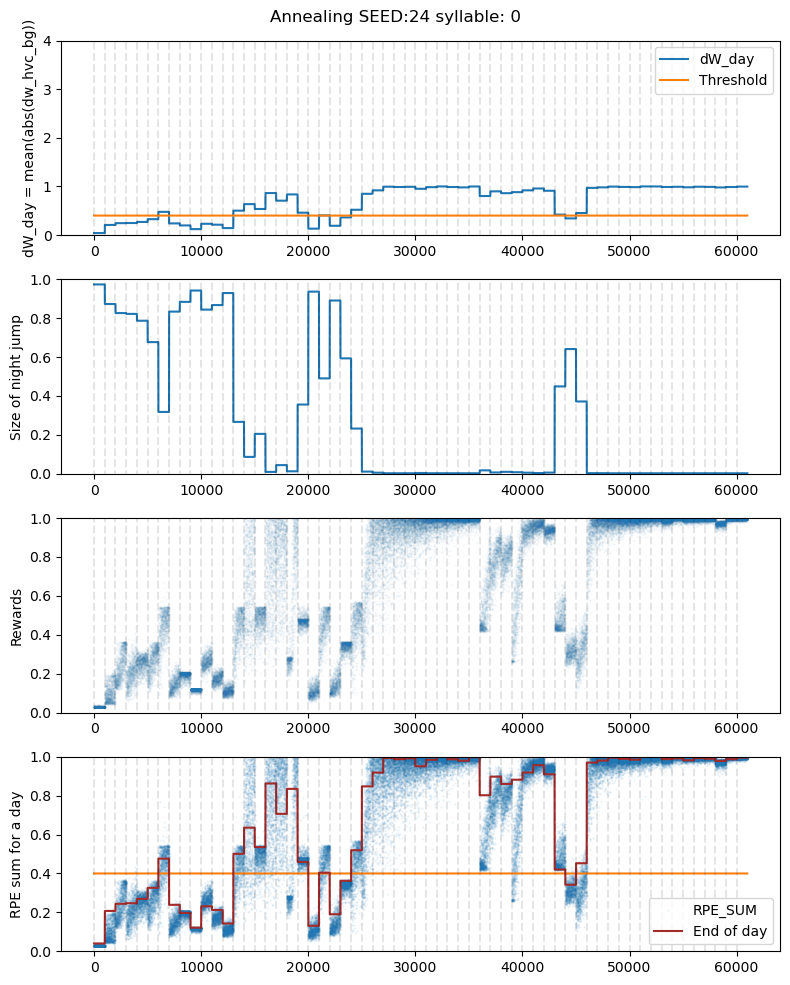

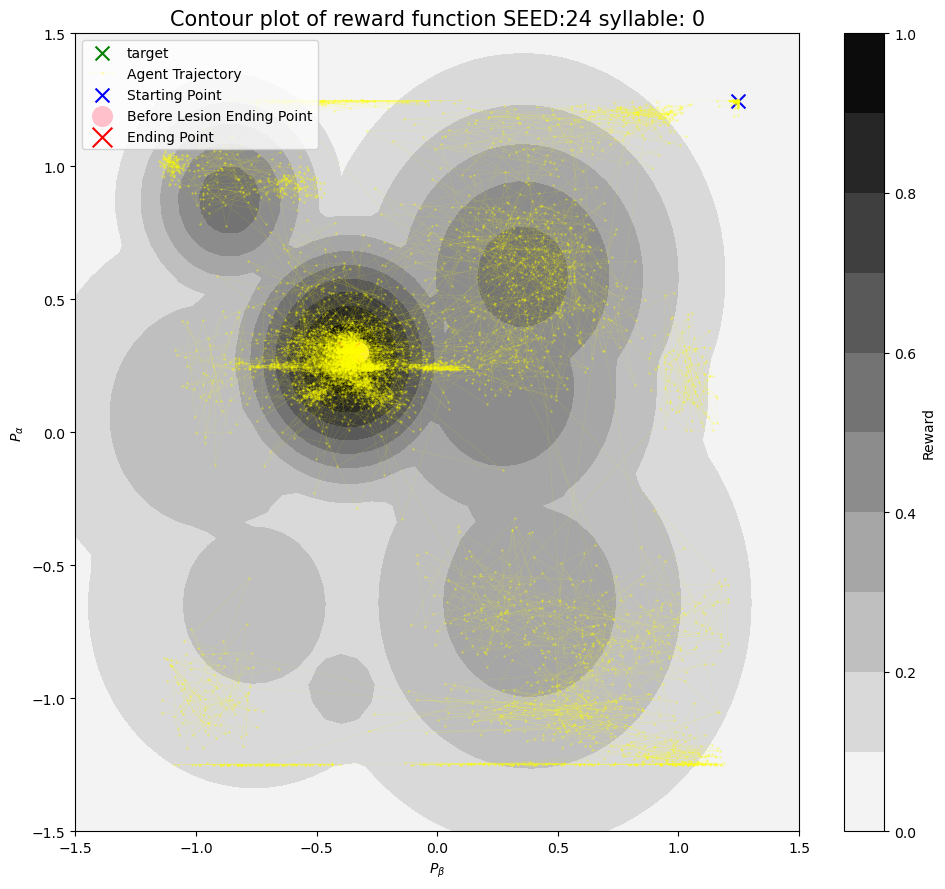

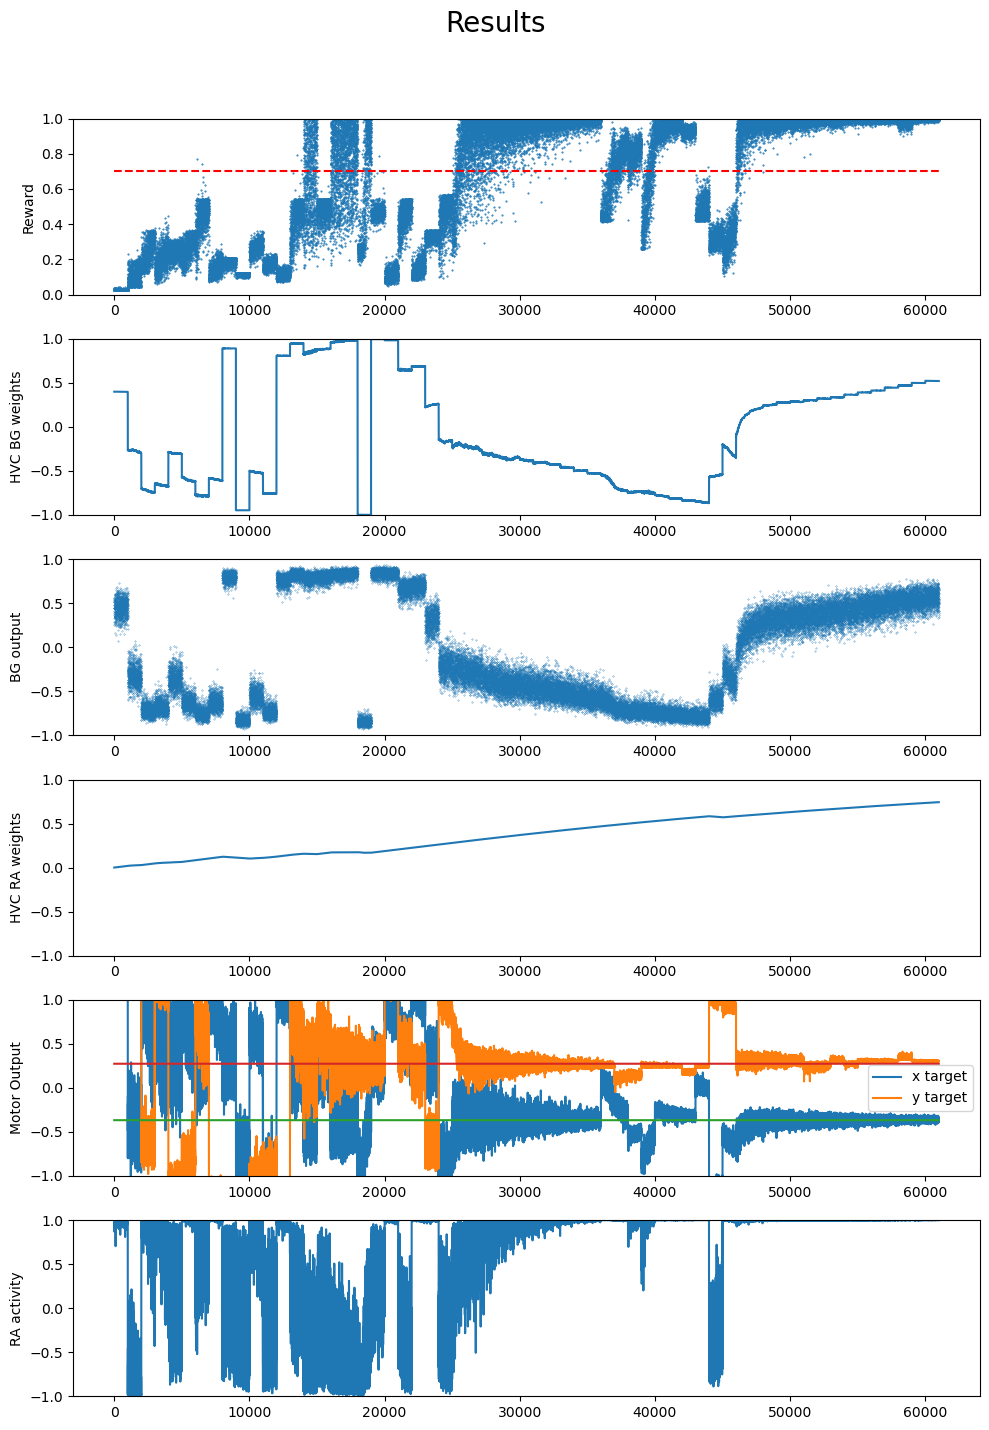

In [21]:
def plot_trajectory(syll):
    fig, axs = plt.subplots(figsize=(10, 9))
    cmap = LinearSegmentedColormap.from_list('white_to_black', ['white', 'black'])
    if LANDSCAPE == 0: # artificial landscape
        x_traj, y_traj = zip(*obj.actions[:,:, syll,:].reshape(-1, 2))
        limit = 1.5
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        # # plot trajectory
        # axs.plot(x_traj[::10], y_traj[::10], 'yellow', label='Agent Trajectory', alpha = 0.1, marker = ".", linewidth = 0.1, markersize = 0.99) # Plot every 20th point for efficiency
        # axs.scatter(x_traj[0], y_traj[0], s=100, c='blue', label='Starting Point', marker = 'x')  # type: ignore # Plot first point as red circle
        # axs.scatter(x_traj[-1001], y_traj[-1001], s=100, c='pink', marker='x', label='Before Lesion Ending Point')
        # axs.scatter(x_traj[-5:], y_traj[-5:], s=100, c='r', marker='x', label='After Leison Point') # type: ignore
        axs.scatter(obj.centers[syll, 0], obj.centers[syll, 1], s=100, c='green', marker='x', label='target')  # type: ignore
    else: 
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        cs = plt.contourf(Z, cmap=cmap, extent=[-1, 1, -1, 1])
        fig.colorbar(cs, ax=axs, label='Reward')
        axs.scatter(target_pos[0], target_pos[1], s=100, c='green', marker='x', label='target')  # type: ignore
        # plot trajectory
    x_traj, y_traj = zip(*obj.actions[:,:, syll,:].reshape(-1, 2))
    axs.plot(x_traj[::10], y_traj[::10], 'yellow', label='Agent Trajectory', alpha = 0.5, linewidth = 0.1, marker='.', markersize = 0.99) # Plot every 20th point for efficiency
    axs.scatter(x_traj[0], y_traj[0], s=100, c='blue', label='Starting Point', marker = 'x')  # type: ignore # Plot first point as red circle
    axs.scatter(x_traj[-1001], y_traj[-1001], s=200, c='pink', marker='o', label='Before Lesion Ending Point')
    axs.scatter(x_traj[-1], y_traj[-1], s=200, c='r', marker='x', label='Ending Point') # type: ignore
    

    # labels
    axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}', fontsize = 15)
    axs.set_ylabel(r'$P_{\alpha}$')
    axs.set_xlabel(r'$P_{\beta}$')
    axs.legend()
    plt.tight_layout()
    plt.show()

expanded_dw_day = np.zeros((DAYS*N_DAILY_MOTIFS))
def plot_dw_day(syll):
    if ANNEALING:
        fig, axs = plt.subplots(4,1,figsize=(8, 10))
        expanded_dw_day_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))
        expanded_pot_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))
        # Expand dw_day_array and pot_array to match the size of rewards
        expanded_dw_day_array = np.repeat(obj.dw_day_array[:, syll], DAYS*N_DAILY_MOTIFS// len(obj.dw_day_array[:, syll]))
        expanded_dw_day = expanded_dw_day_array.reshape(DAYS*N_DAILY_MOTIFS)
        expanded_pot_array = np.repeat(obj.pot_array[:, syll], DAYS*N_DAILY_MOTIFS// len(obj.pot_array[:, syll]))
        fig.suptitle(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
        axs[0].plot(expanded_dw_day_array, markersize=1, label='dW_day')
        axs[0].plot(ANNEALING_MID*np.ones((DAYS*N_DAILY_MOTIFS)), label = 'Threshold')
        axs[0].set_ylabel('dW_day = mean(abs(dw_hvc_bg))')         
        axs[0].set_ylim(0,4) 
        axs[0].legend()
        axs[1].plot(expanded_pot_array, markersize=1, label='Potentiation factor')
        axs[1].set_ylabel('Size of night jump')
        axs[1].set_ylim(0, 1)
        axs[2].plot(obj.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='Reward', alpha = 0.05)
        axs[2].set_ylabel('Rewards')
        axs[2].set_ylim(0, 1)
        axs[3].plot(obj.JUMP_RPE[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='RPE_SUM', alpha = 0.1)
        axs[3].plot(ANNEALING_MID*np.ones((DAYS*N_DAILY_MOTIFS)))
        axs[3].plot(expanded_dw_day_array, markersize=1, label='End of day', color = 'brown')
        axs[3].set_ylabel('RPE sum for a day')
        axs[3].set_ylim(0, 1)    
        for i in range(4):
            axs[i].vlines(range(0, DAYS*N_DAILY_MOTIFS, N_DAILY_MOTIFS), -3, 10, colors='black', linestyles='dashed', alpha = 0.1)           
        plt.tight_layout()
        axs[3].legend()
        plt.show()

def plot_internal(syll):
    fig, axs = plt.subplots(6, 1, figsize=(10, 15))
    axs[0].plot(obj.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, linestyle='None')
    axs[0].hlines(0.7, 0, DAYS*N_DAILY_MOTIFS, colors='r', linestyles='dashed')
    axs[0].set_ylim(0, 1)
    axs[0].set_ylabel('Reward')
    axs[1].plot(obj.hvc_bg_array[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
    axs[1].set_ylim(-1, 1)
    axs[1].set_ylabel('HVC BG weights')
    axs[2].plot(obj.bg_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS),'.', markersize=0.5, linestyle='None')
    axs[2].set_ylim(-1, 1)
    axs[2].set_ylabel('BG output')
    axs[3].plot(obj.hvc_ra_array[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
    axs[3].set_ylim(-1, 1)
    axs[3].set_ylabel('HVC RA weights')
    axs[4].plot(obj.actions[:,:,syll,0].reshape(DAYS*N_DAILY_MOTIFS))
    axs[4].plot(obj.actions[:,:,syll,1].reshape(DAYS*N_DAILY_MOTIFS))
    axs[4].plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS))
    axs[4].plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS))
    axs[4].legend(['x target', 'y target'])
    axs[4].set_ylabel('Motor Output')
    axs[4].set_ylim(-1, 1)
    axs[5].plot(obj.ra_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
    axs[5].set_ylim(-1, 1)
    axs[5].set_ylabel('RA activity')
    fig.suptitle('Results', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # type:ignore
    plt.show()

for i in range(N_SYLL):
    plot_dw_day(i)
    plot_trajectory(i)
    plot_internal(i)

In [22]:
# plot_trajectory(X, Y, Z, x_traj, y_traj, syll) 
# plot_dw_day(0)
# print(expanded_dw_day.reshape(DAYS*N_DAILY_MOTIFS).shape)
# print(env.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS).shape)
# print("Correlations")
# print(np.corrcoef(env.rewards[:,:,0].reshape(DAYS*N_DAILY_MOTIFS), expanded_dw_day)[0,1])    
# print(f"Correlation between Reward and sum RPE: {np.corrcoef(env.rewards[:,:,0].reshape(DAYS*N_DAILY_MOTIFS), env.RPE_SUM[:,:,0].reshape(DAYS*N_DAILY_MOTIFS))[0,1]}")                   
# ra_all = env.generate_results(i)
# env.plot_results(i)


# def build_and_run(seed, annealing, plot):
#     tqdm.write(f" Random seed is {seed}")
#     np.random.seed(seed)
#     env = Environment(HVC_SIZE, BG_SIZE, RA_SIZE, MC_SIZE, RANDOM_SEED)
#     env.run(LEARING_RATE_RL, LEARNING_RATE_HL, ANNEALING)
#     remove_prev_files()
#     for i in range(N_SYLL):
#         env.save_trajectory(i)
#         env.save_results(i)
#         if ANNEALING:
#             env.save_dw_day(i)
#     return np.mean(env.rewards[:,-100:], axis=1)